In [1]:
import sys

# Import mitsuba and set the variant
# To set a variant, you need to have set it in the mitsuba.conf file or use the precompiled ones
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
import mitsuba as mi
mi.set_variant('llvm_ad_rgb')
import drjit as dr

# Import the mitsuba-transient extension
# adds extra functionality to existing Mitsuba
sys.path.insert(1, '../..')
import mitransient as mitr

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


In this tutorial you will learn how to prepare a NLOS scene using our library. We will do it following a programmatically way defining each component independently (note that a conversion directly from an XML like "nlos_Z.xml" is easy to do).

In [2]:
# Load the geometry of the hidden scene
geometry = mi.load_dict(
    {
        "type": "obj",
        "filename": "./Z.obj",
        "to_world": mi.ScalarTransform4f.translate([0.0, 0.0, 1.0]),
        "bsdf": {"type": "diffuse", "reflectance": 1.0},
    }
)

# Load the emitter (laser) of the scene
emitter = mi.load_dict(
    {
        "type": "projector",
        "irradiance": 100.0,
        "fov": 0.2,
        "to_world": mi.ScalarTransform4f.translate([-0.5, 0.0, 0.25]),
    }
)

# Define the transient film which store all the data
transient_film = mi.load_dict(
    {
        "type": "transient_hdr_film",
        "width": 64,
        "height": 64,
        "temporal_bins": 300,
        "bin_width_opl": 0.006,
        "start_opl": 1.85,
        "use_spad": False,
        "rfilter": {"type": "box"},
    }
)

# Define the sensor of the scene
nlos_sensor = mi.load_dict(
    {
        "type": "nlos_capture_meter",
        "sampler": {"type": "independent", "sample_count": 5000},
        "account_first_and_last_bounces": False,
        "sensor_origin": [-0.5, 0.0, 0.25],
        "transient_film": transient_film,
    }
)

# Load the relay wall. This includes the custom "nlos_capture_meter" sensor which allows to setup measure points directly on the shape and importance sample paths going through the relay wall.
relay_wall = mi.load_dict(
    {
        "type": "rectangle",
        "bsdf": {"type": "diffuse", "reflectance": 1.0},
        "nlos_sensor": nlos_sensor,
    }
)

# Finally load the integrator
integrator = mi.load_dict(
    {
        "type": "transient_nlos_path",
        "nlos_laser_sampling": True,
        "nlos_hidden_geometry_sampling": True,
        "nlos_hidden_geometry_sampling_do_rroulette": False,
        "temporal_filter": "box",
    }
)


In [3]:
# Define the transient film which store all the data
transient_film2 = mi.load_dict(
    {
        "type": "transient_hdr_film",
        "width": 64,
        "height": 64,
        "temporal_bins": 300,
        "bin_width_opl": 0.006,
        "start_opl": 1.85,
        "use_spad": True,
        "spad_csv": "../20um_cmos.csv",
        "mod_spad": 10,
        "spad_volt" : 20,
        "spad_lost": 1,
        "rfilter": {"type": "box"},
    }
)

# Define the sensor of the scene
nlos_sensor2 = mi.load_dict(
    {
        "type": "nlos_capture_meter",
        "sampler": {"type": "independent", "sample_count": 5000},
        "account_first_and_last_bounces": False,
        "sensor_origin": [-0.5, 0.0, 0.25],
        "transient_film": transient_film2,
    }
)

# Load the relay wall. This includes the custom "nlos_capture_meter" sensor which allows to setup measure points directly on the shape and importance sample paths going through the relay wall.
relay_wall2 = mi.load_dict(
    {
        "type": "rectangle",
        "bsdf": {"type": "diffuse", "reflectance": 1.0},
        "nlos_sensor": nlos_sensor2,
    }
)

# Assemble the final scene
scene2 = mi.load_dict({
    'type' : 'scene',
    'geometry' : geometry,
    'emitter' : emitter,
    'relay_wall' : relay_wall2,
    'integrator' : integrator
})

In [4]:
# Define the transient film which store all the data
transient_film3 = mi.load_dict(
    {
        "type": "transient_hdr_film",
        "width": 64,
        "height": 64,
        "temporal_bins": 300,
        "bin_width_opl": 0.006,
        "start_opl": 1.85,
        "use_spad": True,
        "spad_csv": "../20um_cmos.csv",
        "mod_spad": 10,
        "spad_volt": 5,
        "spad_lost": 1,
        "rfilter": {"type": "box"},
    }
)

# Define the sensor of the scene
nlos_sensor3 = mi.load_dict(
    {
        "type": "nlos_capture_meter",
        "sampler": {"type": "independent", "sample_count": 5000},
        "account_first_and_last_bounces": False,
        "sensor_origin": [-0.5, 0.0, 0.25],
        "transient_film": transient_film3,
    }
)

# Load the relay wall. This includes the custom "nlos_capture_meter" sensor which allows to setup measure points directly on the shape and importance sample paths going through the relay wall.
relay_wall3 = mi.load_dict(
    {
        "type": "rectangle",
        "bsdf": {"type": "diffuse", "reflectance": 1.0},
        "nlos_sensor": nlos_sensor3,
    }
)

# Assemble the final scene
scene3 = mi.load_dict({
    'type' : 'scene',
    'geometry' : geometry,
    'emitter' : emitter,
    'relay_wall' : relay_wall3,
    'integrator' : integrator
})

In [5]:
# Assemble the final scene
scene = mi.load_dict({
    'type' : 'scene',
    'geometry' : geometry,
    'emitter' : emitter,
    'relay_wall' : relay_wall,
    'integrator' : integrator
})

In [6]:
# Now we focus the emitter to irradiate one specific pixel of the "relay wall"
pixel = mi.Point2f(32, 32)
mitr.nlos.focus_emitter_at_relay_wall_pixel(pixel, relay_wall, emitter)

In [7]:
# Prepare transient integrator for transient path tracing
# Does the work to initialize the scene before path tracing
transient_integrator = scene.integrator()
transient_integrator.prepare_transient(scene, sensor=0)
# sensor=0 just tells it to use the first sensor in the scene
# (in case there is more than one sensor in the XML file)

In [8]:
# Render the scene and develop the data
data_steady, data_transient = transient_integrator.render(scene)
# And evaluate the output to launch the corresponding kernel
dr.eval(data_steady, data_transient)

In [9]:
mitr.nlos.focus_emitter_at_relay_wall_pixel(pixel, relay_wall2, emitter)
# Prepare transient integrator for transient path tracing
# Does the work to initialize the scene before path tracing
transient_integrator2 = scene2.integrator()
transient_integrator2.prepare_transient(scene2, sensor=0)
# sensor=0 just tells it to use the first sensor in the scene
# (in case there is more than one sensor in the XML file)
# Render the scene and develop the data
data_steady2, data_transient2 = transient_integrator2.render(scene2)
# And evaluate the output to launch the corresponding kernel
dr.eval(data_steady2, data_transient2)

In [10]:
mitr.nlos.focus_emitter_at_relay_wall_pixel(pixel, relay_wall3, emitter)
# Prepare transient integrator for transient path tracing
# Does the work to initialize the scene before path tracing
transient_integrator2 = scene3.integrator()
transient_integrator2.prepare_transient(scene3, sensor=0)
# sensor=0 just tells it to use the first sensor in the scene
# (in case there is more than one sensor in the XML file)
# Render the scene and develop the data
data_steady2, data_transient3 = transient_integrator2.render(scene3)
# And evaluate the output to launch the corresponding kernel
dr.eval(data_steady2, data_transient3)

In [11]:
'''
You cannot see much in data_steady because it's the sum over
the temporal domain for the data captured at the relay wall
so there is no temporal information.
The temporal information is what allows you
to see around corners easier :)
'''
mi.util.convert_to_bitmap(data_steady)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [12]:
'''
data_transient is a 4D array represented as a Dr.JIT's TensorXf class.
It is very similar to a numpy array (in fact, you can convert between
the two by using np.array(data_transient))
'''
print(data_transient.__class__.__name__)
# The channels represent (x, y, time, rgb)
print(data_transient.shape)

TensorXf
(64, 64, 300, 3)


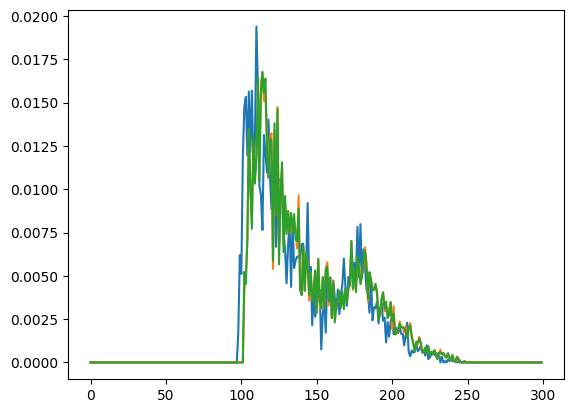

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# There are two main ways of plotting data_transient
# The first one is to plot a single pixel's time-resolved response
plt.plot(np.array(data_transient)[0, 0, :, 0])
plt.plot(np.array(data_transient2)[0, 0, :, 0])
plt.plot(np.array(data_transient3)[0, 0, :, 0])

In [14]:
def plot_transient_data(data_transient,_vmax=0):
    # Divide los datos para cada imagen
    num_images = 4
    image_data = [np.array(data_transient)[:, :, 30+i*15:30+(i+1)*15, 0] for i in range(num_images)]

    # Calcula el rango común de valores para todas las imágenes
    vmin = min(np.min(image) for image in image_data)
    vmax = max(np.max(image) for image in image_data)
    vmax = max(_vmax, vmax)

    # Configura subplots
    fig, axs = plt.subplots(1, num_images, figsize=(4 * num_images, 4))

    # Muestra cada imagen en un subplot diferente
    for i, ax in enumerate(axs):
        ax.imshow(np.fliplr(image_data[i][:, :, 0].T), cmap='jet', vmin=vmin, vmax=vmax)

    # Añade una barra de color común para todas las imágenes
    fig.colorbar(axs[0].imshow(np.fliplr(image_data[0][:, :, 0].T), cmap='jet', vmin=vmin, vmax=vmax), ax=axs, orientation='vertical')

    plt.show()
    return vmax

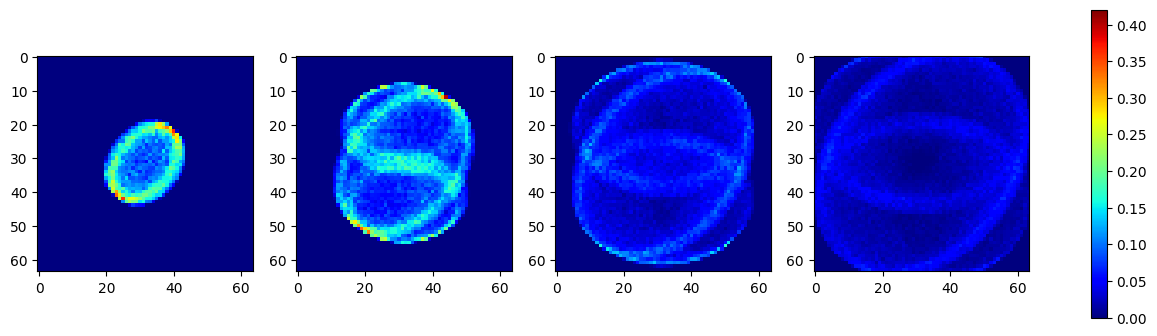

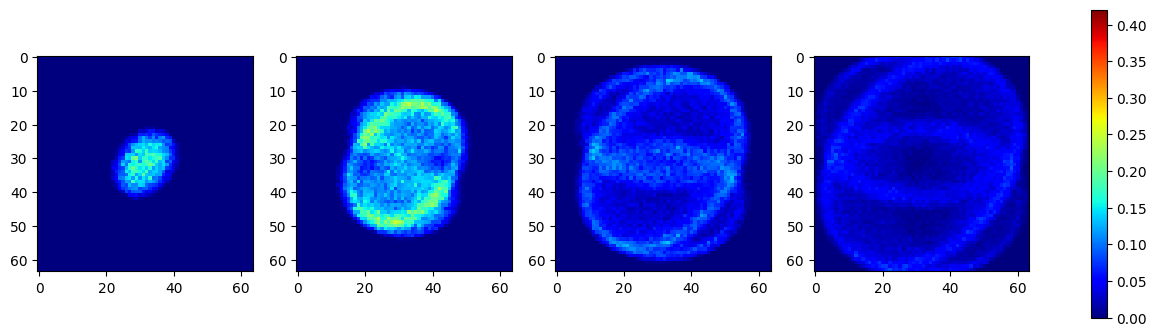

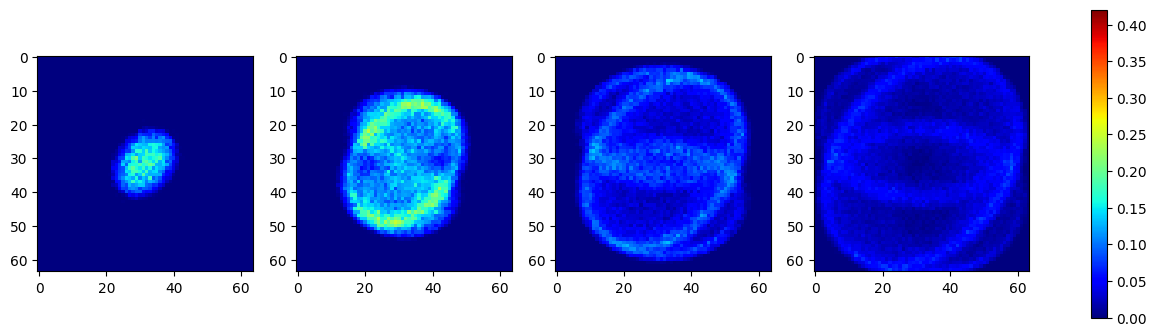

0.42067593

In [15]:

vmax = plot_transient_data(data_transient)
vmax = plot_transient_data(data_transient2,vmax)
plot_transient_data(data_transient3,vmax)

In [16]:
# Mitsuba transient offers a utility function to show videos
# although it is mostly unused in NLOS simulations

# mitr.utils.show_video(np.moveaxis(data_transient, 0, 1), 2, uint8_srgb=True)